# Классификация нуклеотидов на принадлежность к неканоническим спариваниям с помощью RNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from f723.tools.models.nt_rnn import NucleotideRNN
from f723.tools.dataset.features import NucleotideFeaturesExtractor
from f723.tools.dataset.transformers import join_features, normalize_features, pack_neighbours
from f723.tools.models.application import ClassificationResult
from f723.tools.show.classification import show_classification_result
from f723.tools.dataset.utils import split_feature_vector

from sklearn.model_selection import GroupKFold

%matplotlib inline

TL;DR скоры RNN для классификации нуклеотидов по принадлежности к спариваниям получаются приблизительно такие же, как у random forest.

Модель такая: берем все понуклеотидные фичи. Берем нуклеотид, и несколько его соседей по цепочке. Далее проходимся по получившейся последовательности bidirectional lstm'кой, выходы нормируем. Получается, что lstm'ка отобразила каждый нуклеотид на сферу радиуса 1 некоторого пространства $R^n$. Далее возьмем некоторую обучаемую матрицу $A$ векторов длины 1 в $R^n$. Домножим $A$ на выходы lstm'ки, получим для каждого нуклеотида скалярные произведения его вектора на вектора из $A$. Возьмем максимум из этих скалярных произведений и скормим его в log loss.  
Что мы сделали неформально: мы отобразили каждый нуклеотид на сферу. Также мы обучили несколько векторов (то есть матрицу $A$), таких что если вектор нуклеотида находится близко к ним, то максимум скалярного произведения велик, и он считается принадлежащим к неканоническому спариванию. Все нуклеотиды, которые не принадлежат неканоническим спариваниям будут в процессе обучения отталкиваться от векторов из $A$

In [4]:
NEIGHBOURS_NUM = 3

In [5]:
nfe = NucleotideFeaturesExtractor(
    nrlist_path='/home/mikhail/bioinformatics/data/nrlist_3.76_3.0A.csv', 
    cif_dir='/home/mikhail/bioinformatics/data/NR_3.0/cif/', 
    out_dir='/home/mikhail/bioinformatics/data/NR_3.0/out/', 
    sec_struct_dir='/home/mikhail/bioinformatics/data/sec_struct', 
    chains_for_classification_path='/home/mikhail/bioinformatics/data/chains_for_classification.json', 
    max_pair_dist=60)

In [6]:
nucleotide_feature_vector = nfe.make_dataset()

100%|██████████| 341/341 [00:45<00:00,  7.44it/s]


In [7]:
feature_vector = join_features(nucleotide_feature_vector)
normalized_feature_vector = normalize_features(feature_vector)
packed_feature_vector, new_index = pack_neighbours(normalized_feature_vector, NEIGHBOURS_NUM)

loss: 0.4460456669330597; alpha: 3.7488973140716553


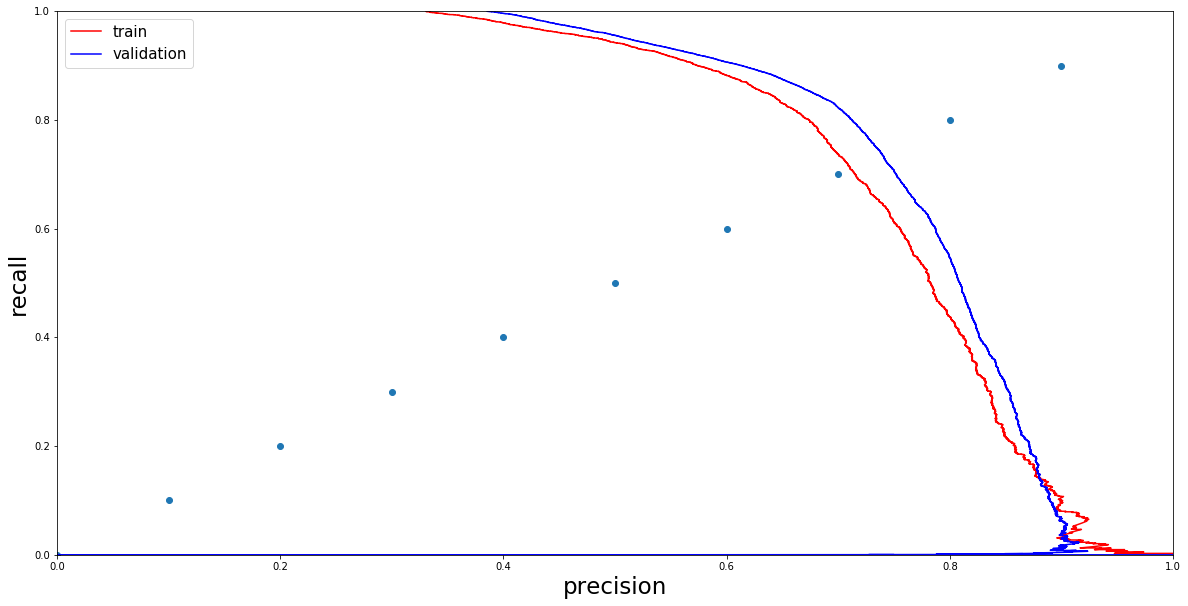

loss: 0.3983106017112732; alpha: 5.240036964416504


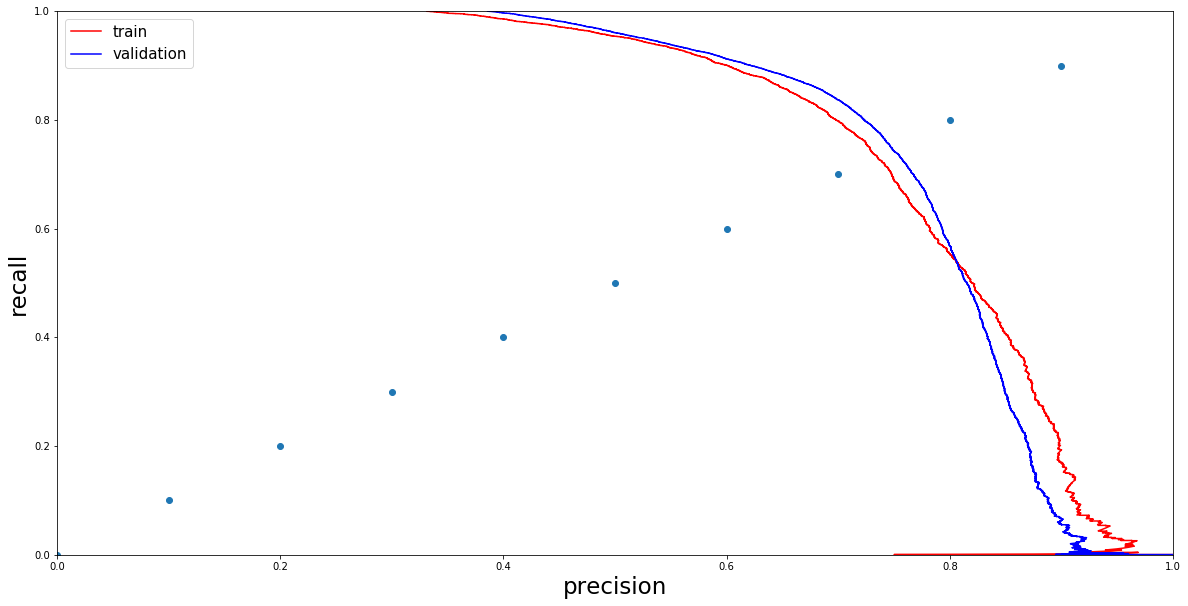

loss: 0.37675824761390686; alpha: 6.90657377243042


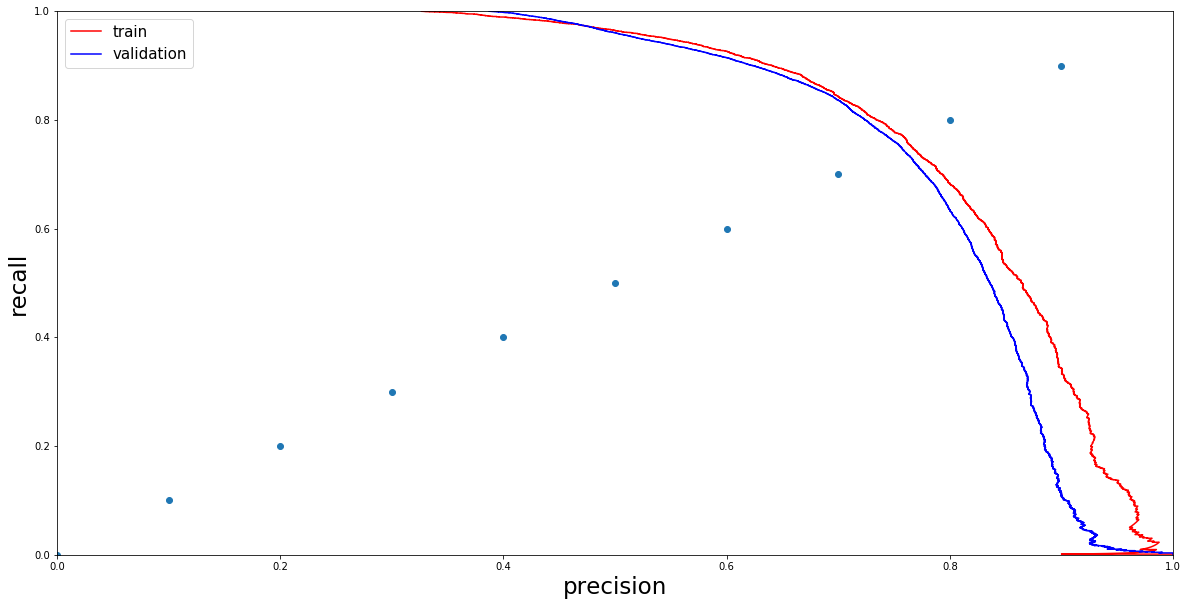

loss: 0.35812994837760925; alpha: 8.377039909362793


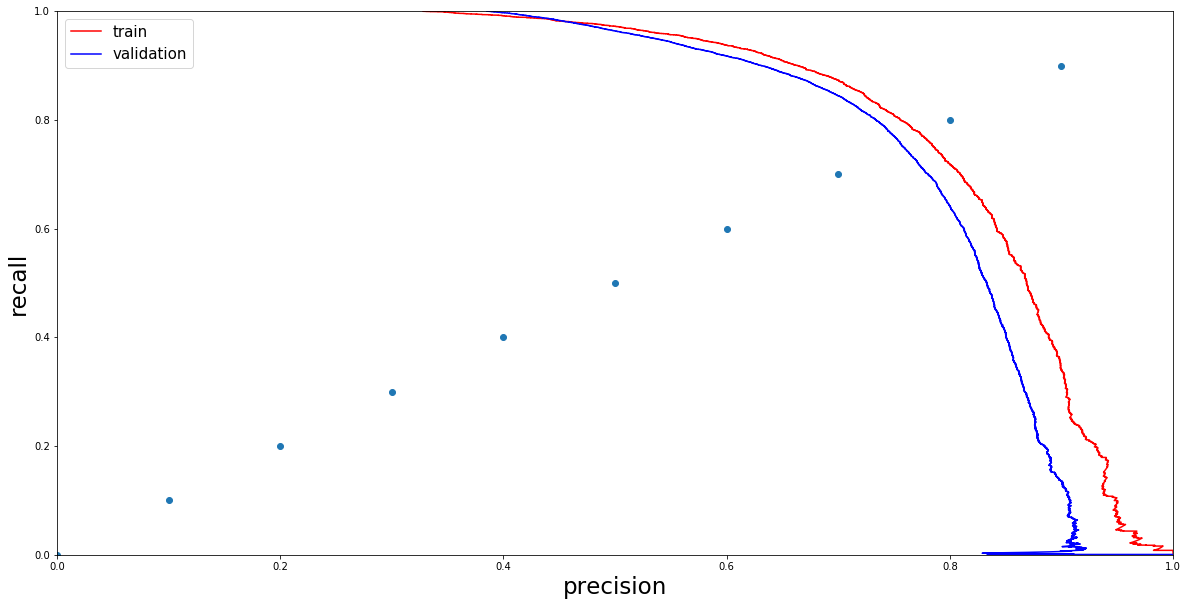

loss: 0.34353044629096985; alpha: 9.830166816711426


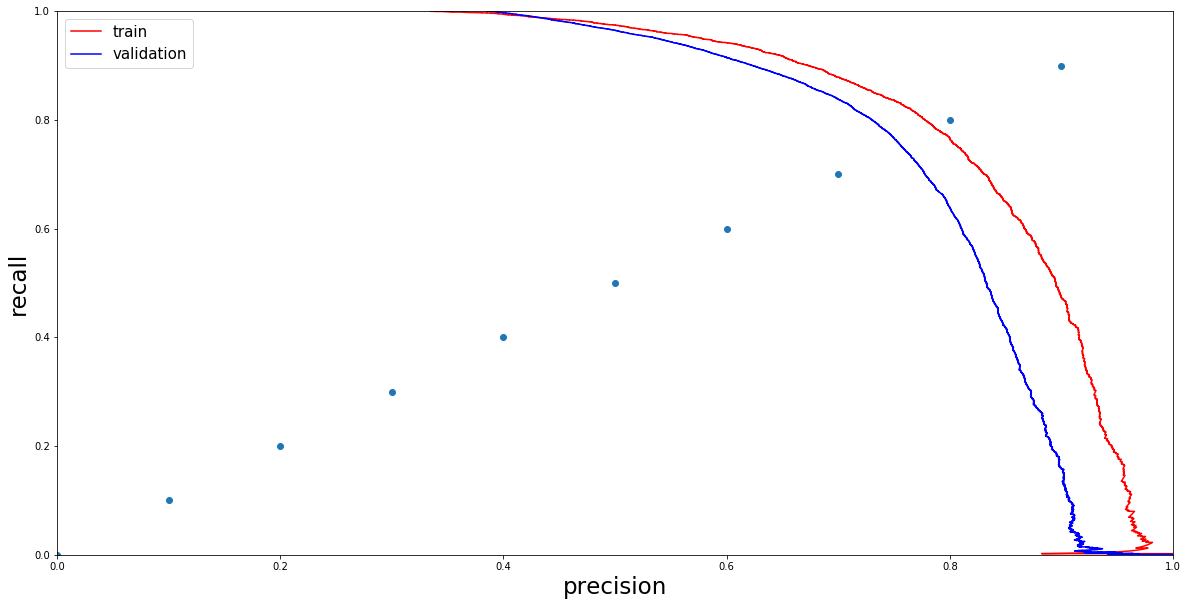

loss: 0.4526645541191101; alpha: 3.6561853885650635


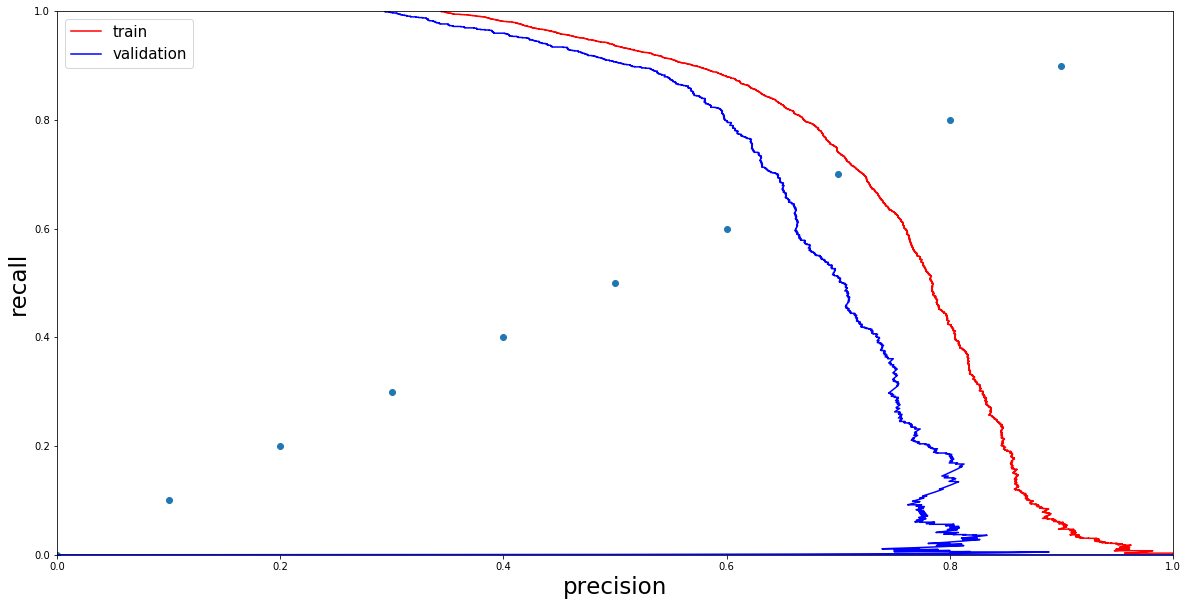

loss: 0.41117992997169495; alpha: 5.086545467376709


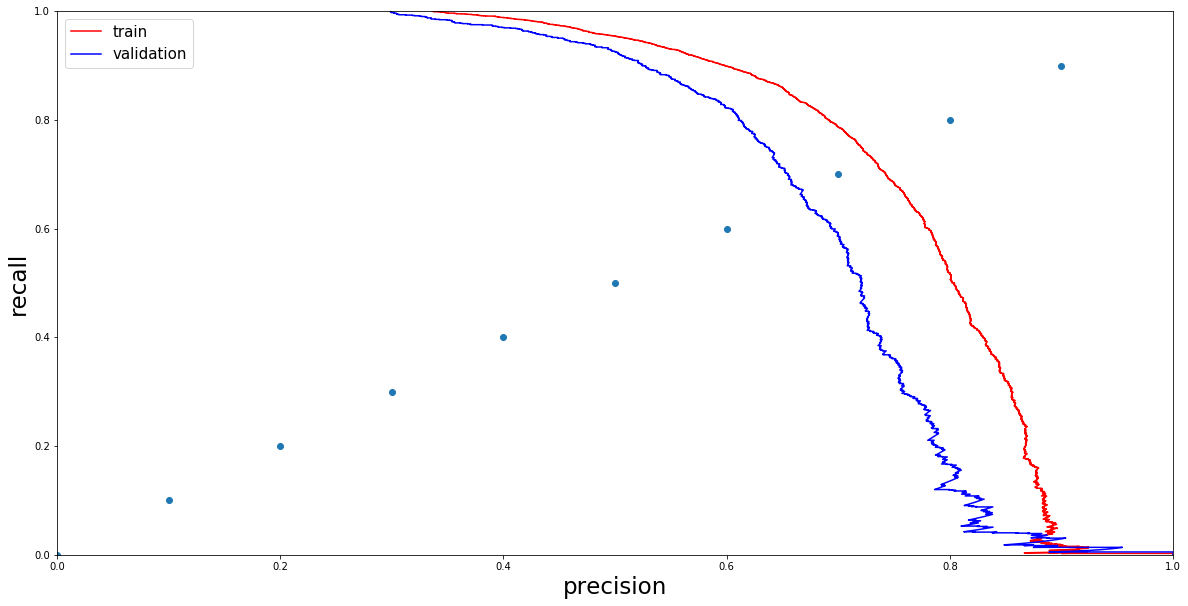

loss: 0.3905993103981018; alpha: 6.42606782913208


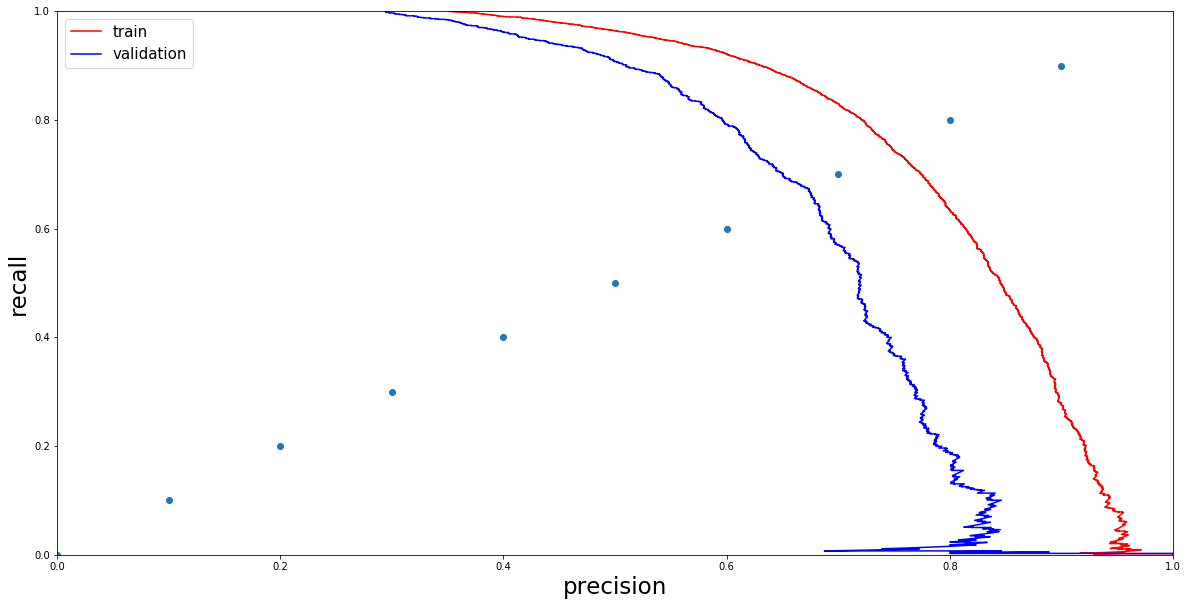

loss: 0.37375152111053467; alpha: 7.806312561035156


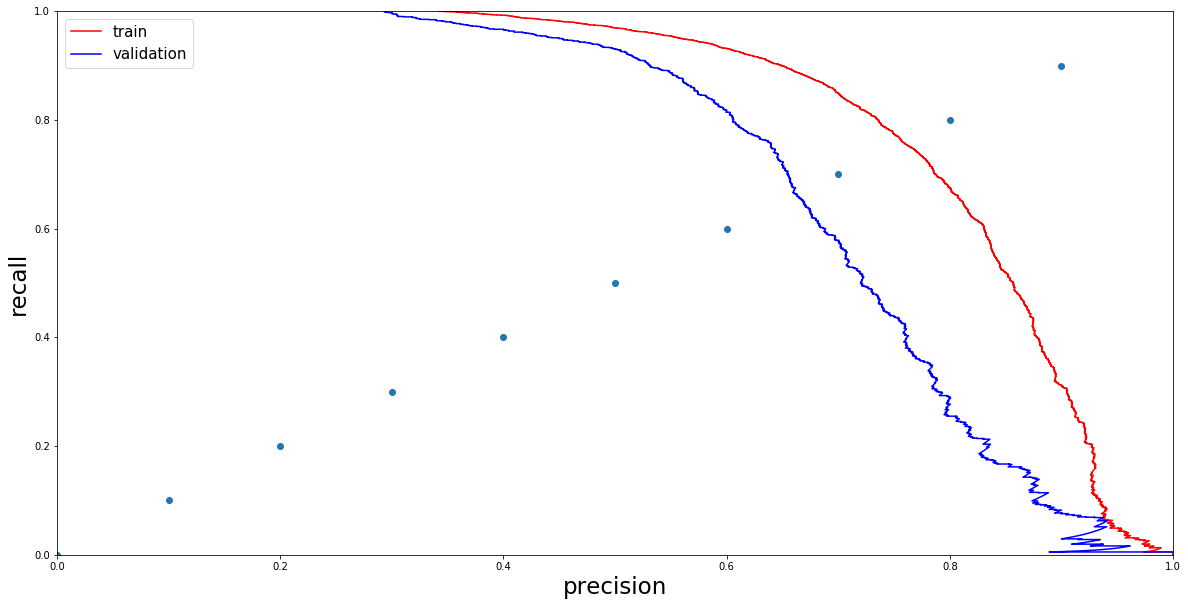

loss: 0.36387598514556885; alpha: 8.982132911682129


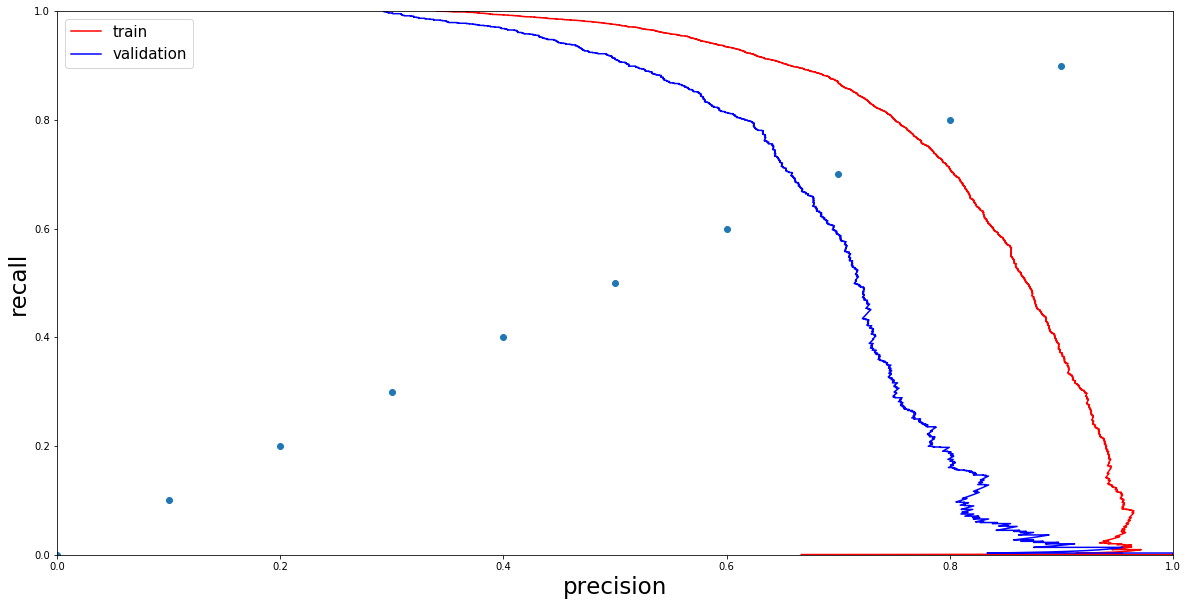

loss: 0.4526212811470032; alpha: 3.6739766597747803


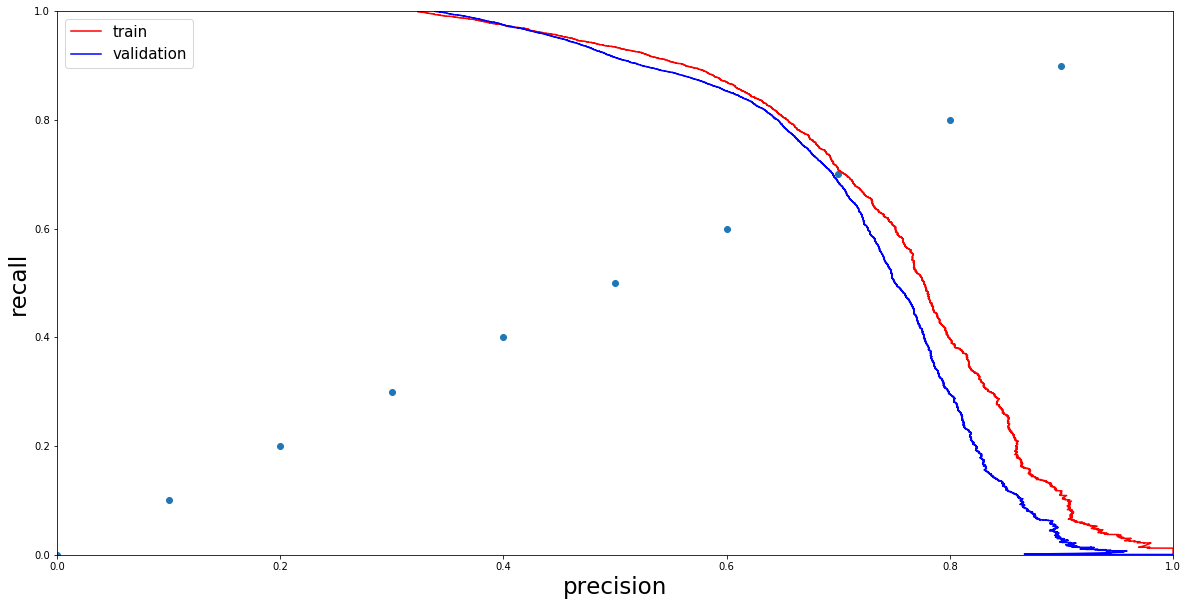

loss: 0.40875133872032166; alpha: 5.046928405761719


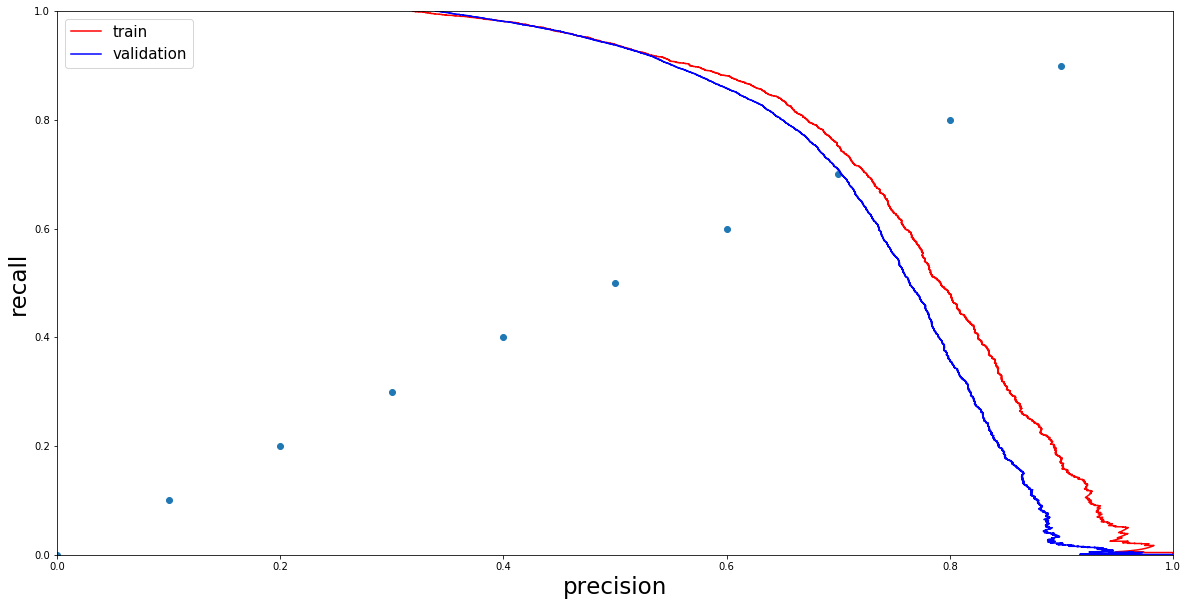

loss: 0.3911367356777191; alpha: 6.3805084228515625


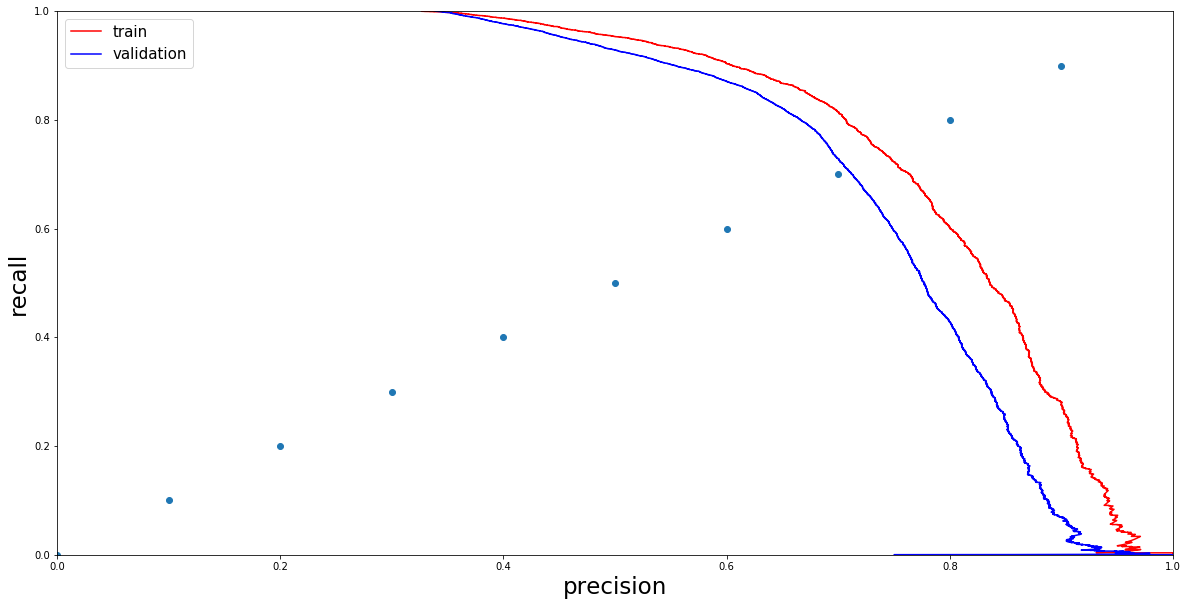

loss: 0.368490993976593; alpha: 7.932501792907715


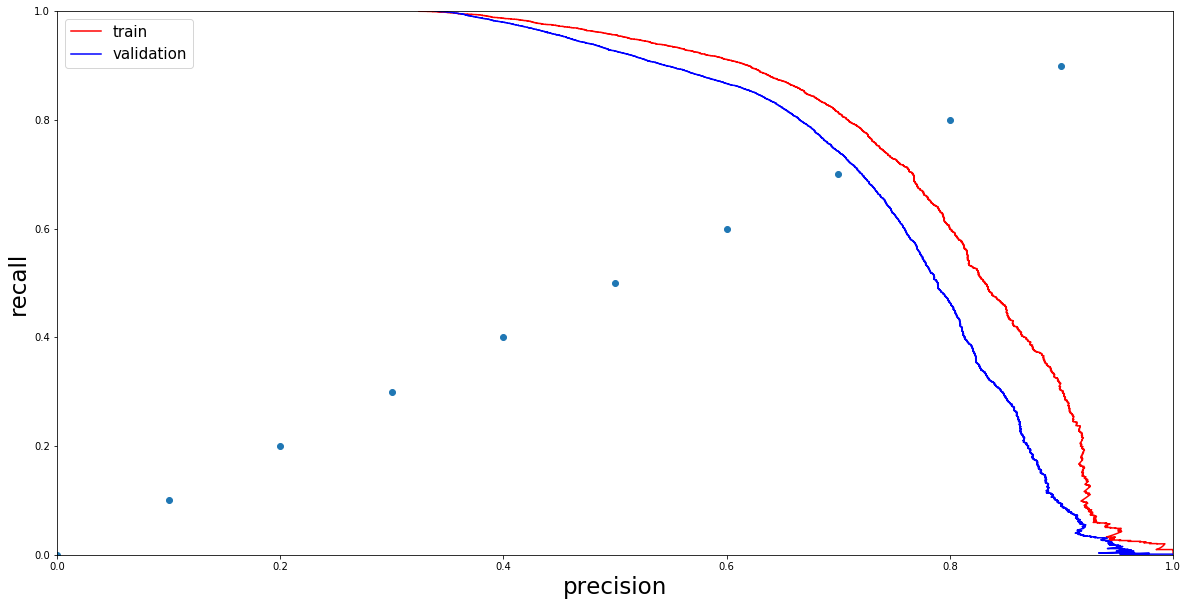

loss: 0.3622937798500061; alpha: 9.228338241577148


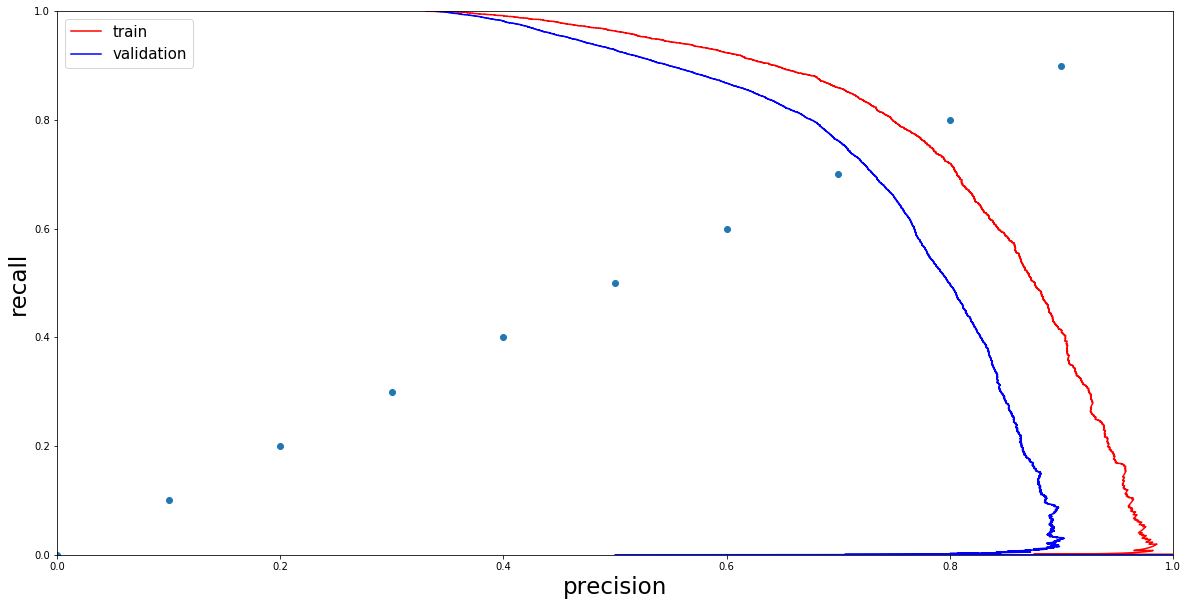

loss: 0.4527871608734131; alpha: 3.6818718910217285


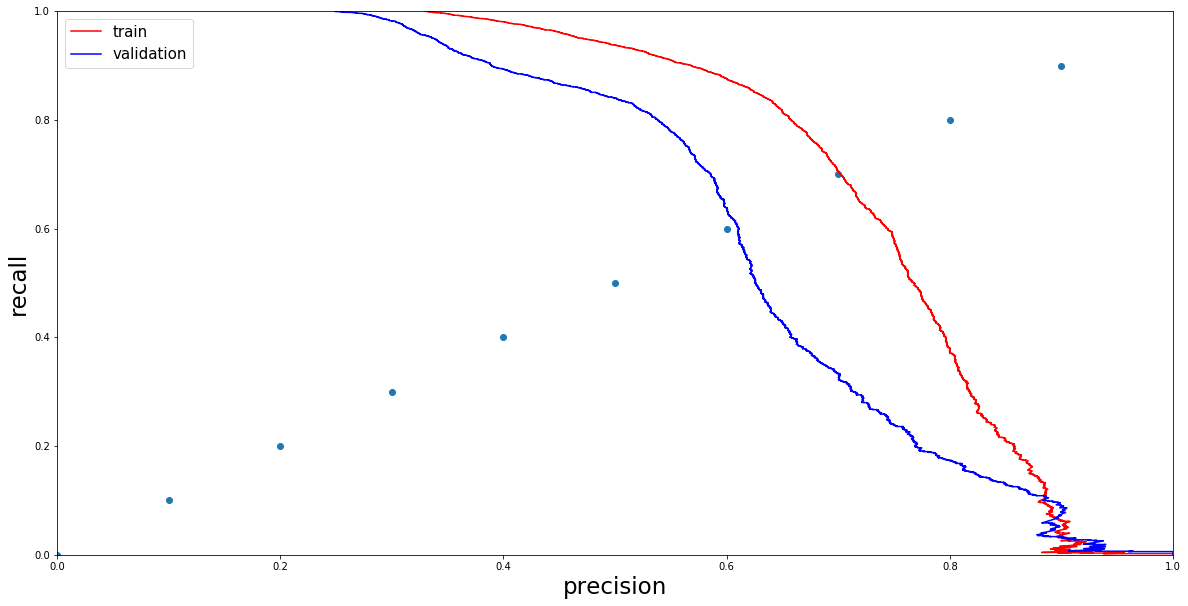

loss: 0.4138326346874237; alpha: 4.973797798156738


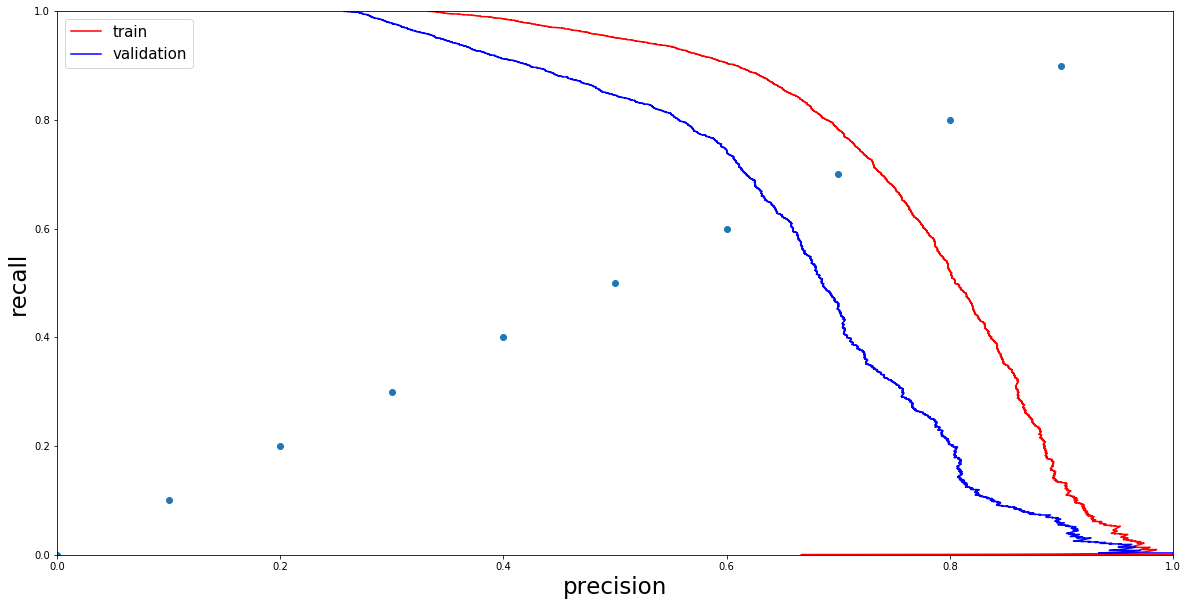

loss: 0.39483532309532166; alpha: 6.26467752456665


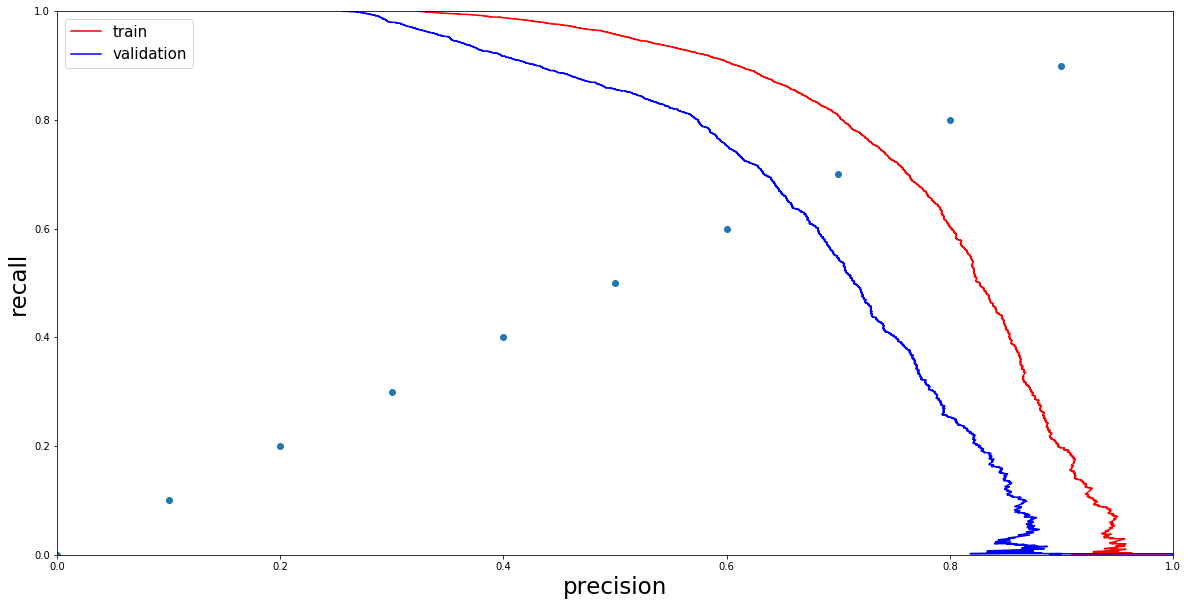

loss: 0.3811556398868561; alpha: 7.61612606048584


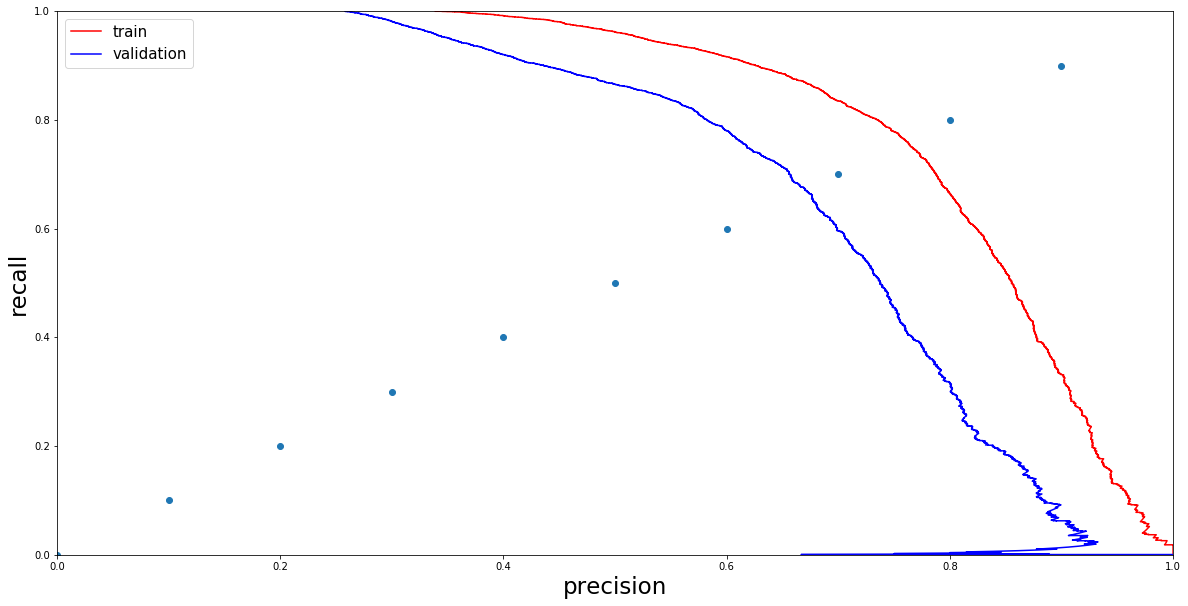

loss: 0.3690027892589569; alpha: 8.806543350219727


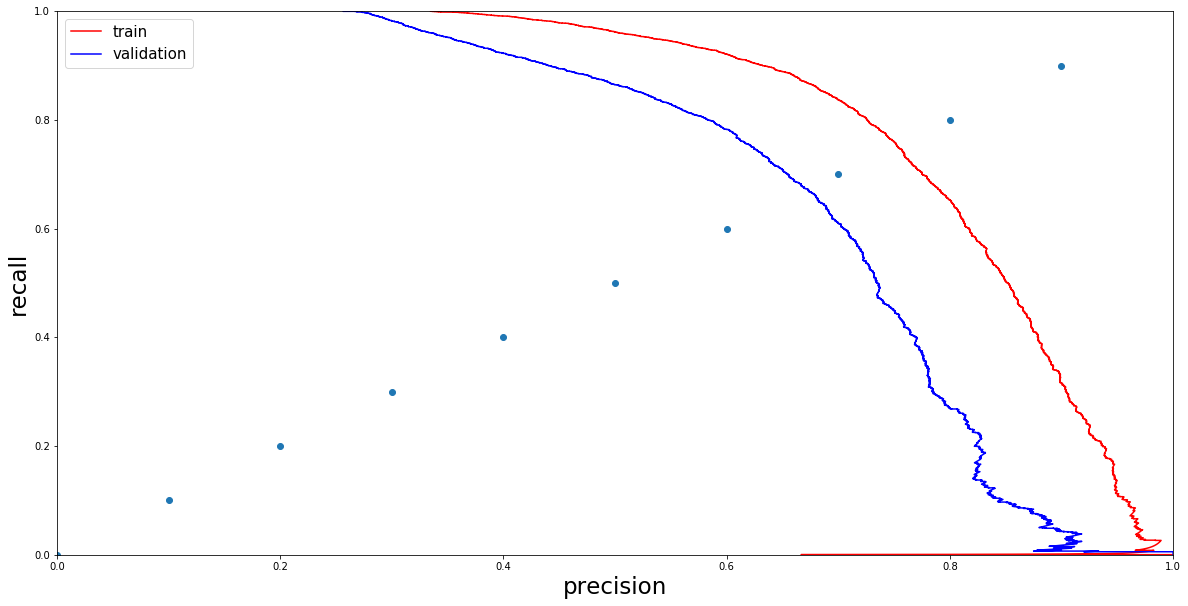

loss: 0.45912089943885803; alpha: 3.5712034702301025


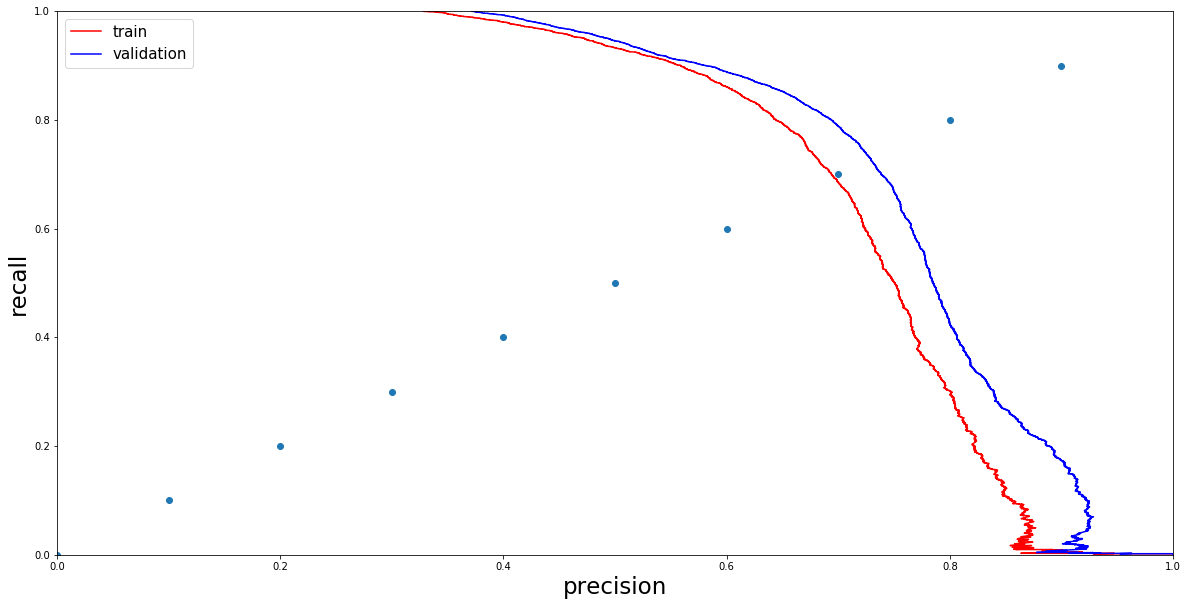

loss: 0.41641518473625183; alpha: 4.901203155517578


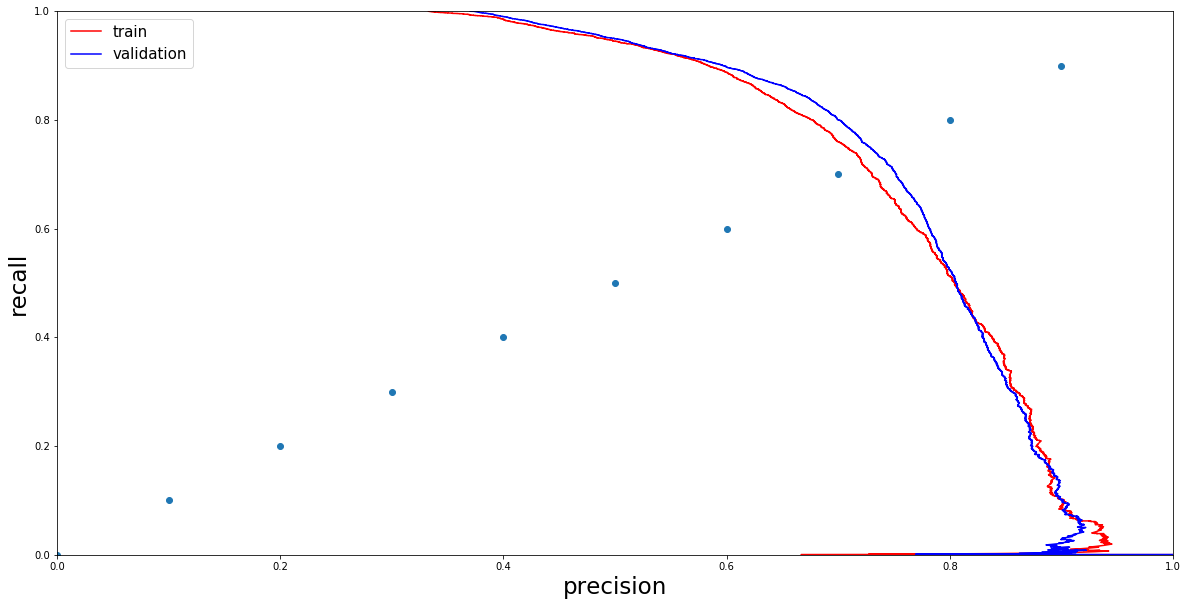

loss: 0.3934818208217621; alpha: 6.283657073974609


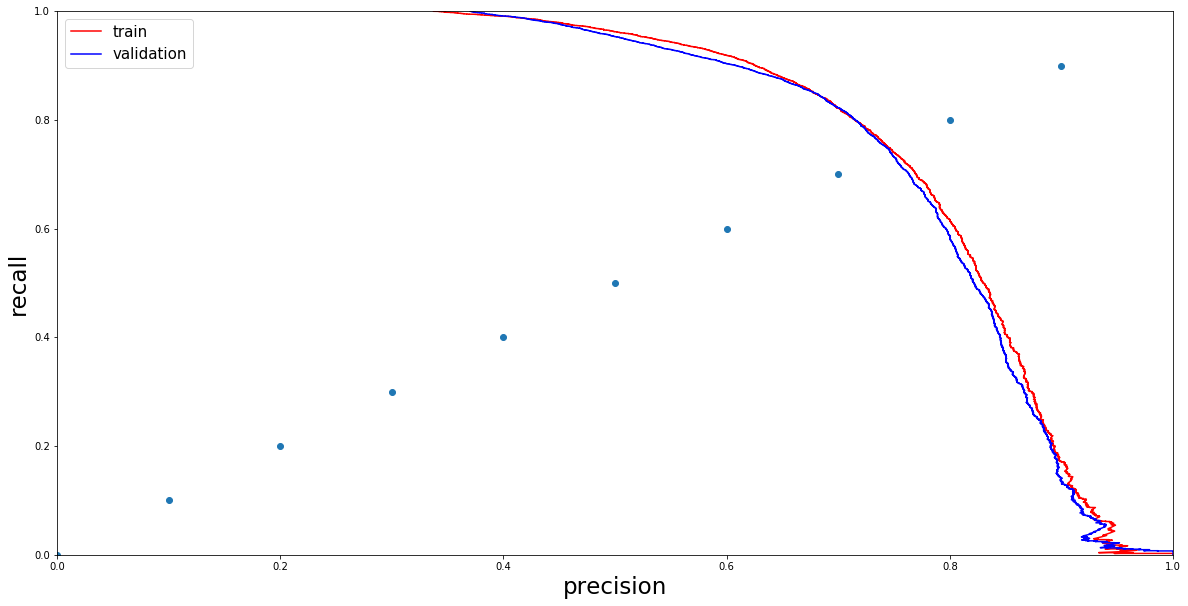

loss: 0.37852129340171814; alpha: 7.700357437133789


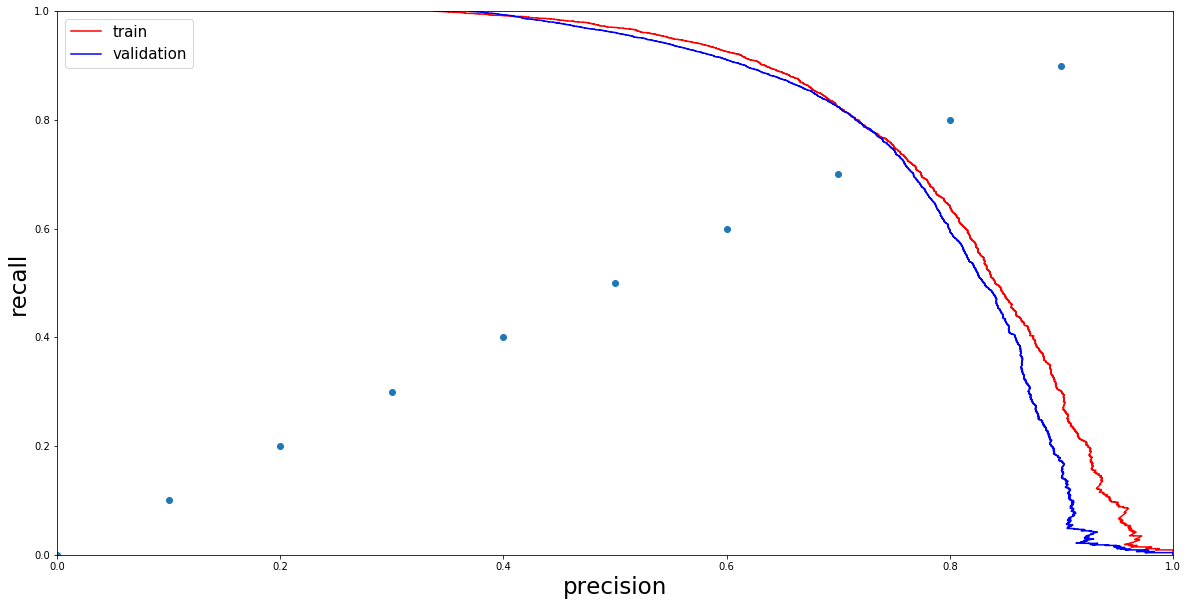

loss: 0.3698083758354187; alpha: 8.861326217651367


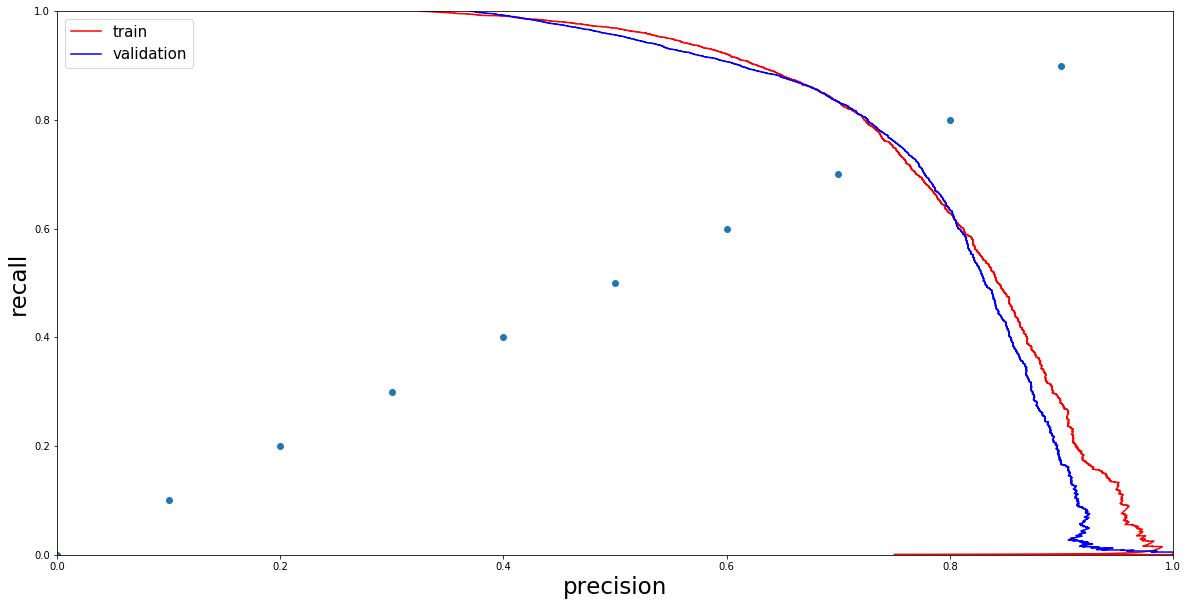

In [15]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(packed_feature_vector.features, groups=packed_feature_vector.pdb_ids)

predicted_proba = np.zeros_like(packed_feature_vector.target[:, NEIGHBOURS_NUM], dtype=np.float32)

for train_index, test_index in group_kfold.split(packed_feature_vector.features, groups=packed_feature_vector.pdb_ids):
    rnn = NucleotideRNN(
        neighbours_num=NEIGHBOURS_NUM, 
        batch_size=30, 
        epoch_size=1000, 
        hidden_size=64, 
        discriminator_size=5, 
        num_epochs=5,
        validation_rate=0.05)
    rnn_train, rnn_test = split_feature_vector(packed_feature_vector, [train_index, test_index])
    rnn.fit(rnn_train)
    
    test_rnn_proba = rnn.predict_proba(rnn_test.features)
    
    predicted_proba[test_index] = test_rnn_proba

In [16]:
cr = ClassificationResult(
    target=packed_feature_vector.target[:, NEIGHBOURS_NUM], 
    predicted=predicted_proba > 0.5, 
    predicted_proba=predicted_proba)

precision_recall_fscore_support
(array([0.85352183, 0.71906951]), array([0.86262413, 0.7037224 ]), array([0.85804884, 0.71131318]), array([43603, 21787]))


<Figure size 1440x720 with 0 Axes>

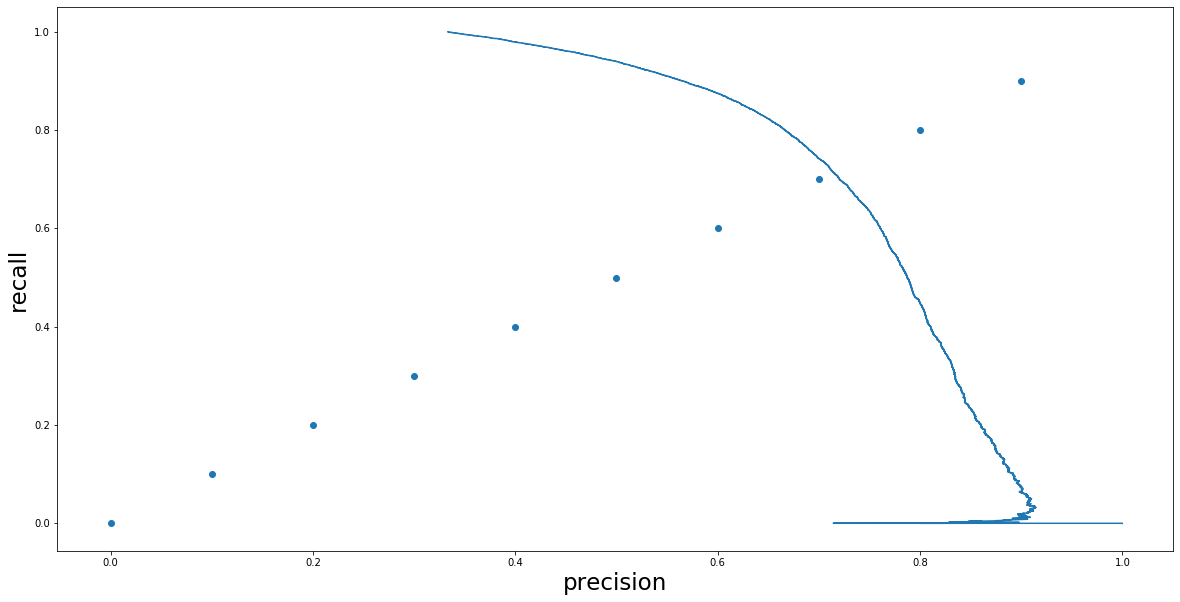

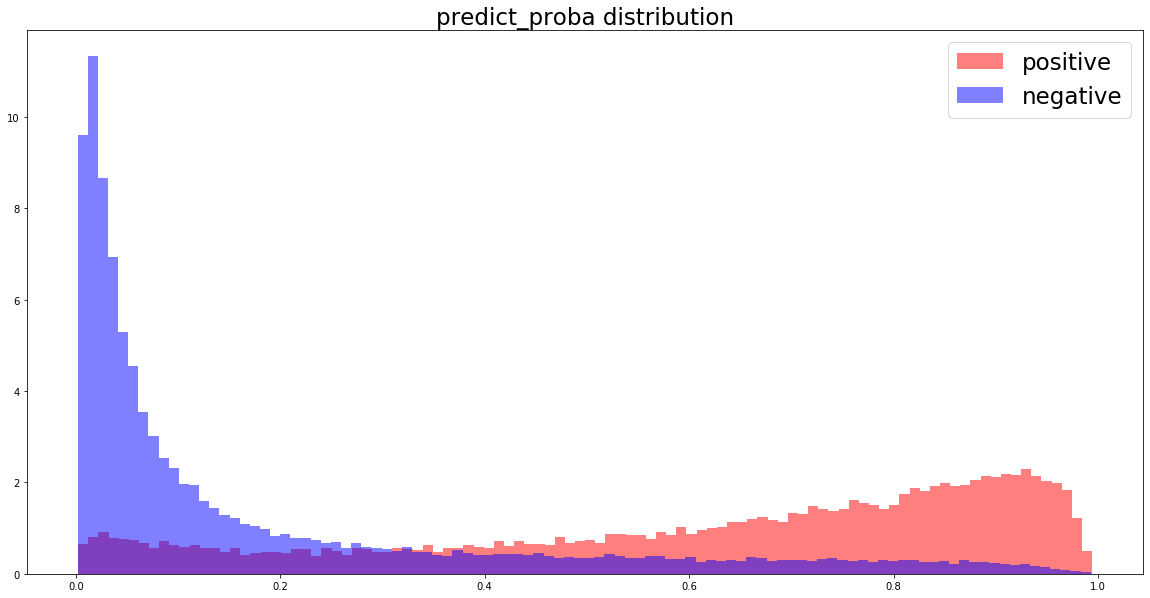

roc auc
0.868483662548675


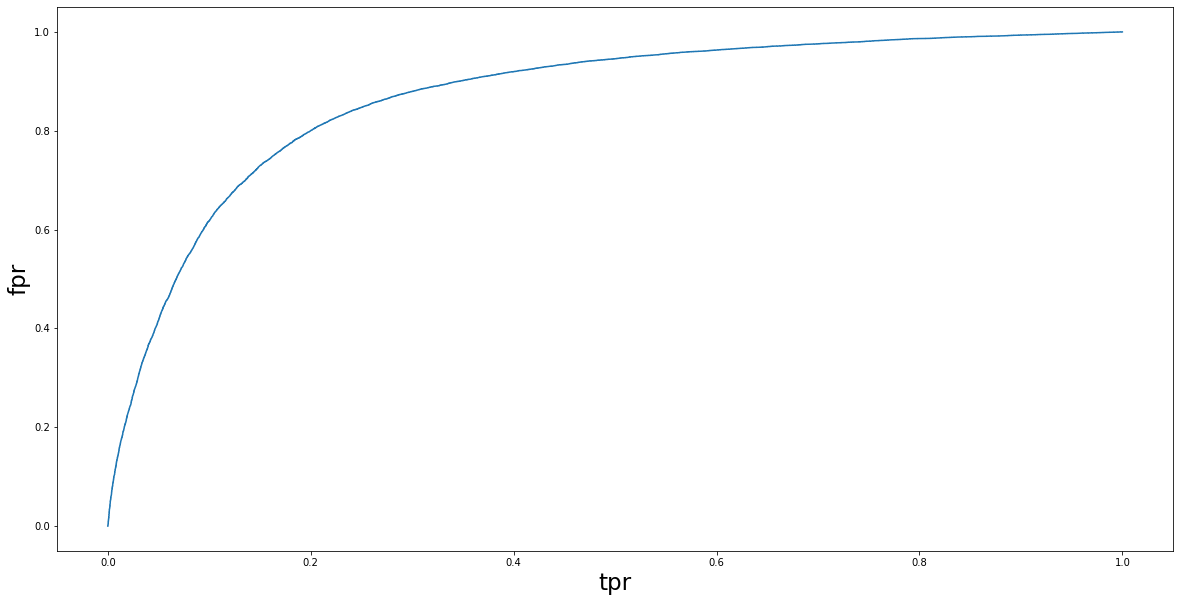

In [17]:
plt.figure(figsize=(20, 10))

show_classification_result(cr)